## Steps of Calculation

In [2]:
import galois
import numpy as np
import sys
sys.path.append('../../doubling-CSST/')
from convert_alist import readAlist
alistDirPath = "../../doubling-CSST/alistMats/GO03_self_dual/"
# The following are the parameters of the self-dual code included in the alistDirPath
length_dist_dict = {4:2, 6:2, 8:2, 10:2, 12:4, 14:4, 16:4, 18:4, 20:4, 22:6, 24:6, 26:6, 28:6, 30:6, 32:8, 34:6, 36:8, 38:8, 40:8, 42:8, 44:8, 46:8, 48:8, 50:8, 52:10, 54:8, 56:10, 58:10, 60:12, 62:10, 64:10}

n = 12 # all even lengths from 4 to 64
d = length_dist_dict[n]
F2 = galois.GF(2)
alistFilePath = alistDirPath + "n" + str(n) + "_d" + str(d) + ".alist"

GenMat = F2(readAlist(alistFilePath))
G_punctured = GenMat[:, :-1]  # Puncture the last column
print("Punctured code: [n=%s,k=%s]" % (G_punctured.shape[1], G_punctured.shape[0]))
H_punctured = G_punctured.null_space() # Parity-check matrix of the punctured code = generator matrix of the dual of the punctured code
print("Dual of the punctured code: [n=%s,k=%s]" % (H_punctured.shape[1], H_punctured.shape[0]))
print(H_punctured)
H_CSS = np.block([
    [H_punctured, np.zeros_like(H_punctured)],
    [np.zeros_like(H_punctured), H_punctured]
]); 
print("The sympletic matrix of the self-dual CSS code [[n=%s,k=%s, d>=%s]]:\n" % (H_punctured.shape[1], H_punctured.shape[1]-2*H_punctured.shape[0], d-1))
H_CSS

Punctured code: [n=11,k=6]
Dual of the punctured code: [n=11,k=5]
[[1 0 1 0 0 0 0 0 1 0 1]
 [0 1 1 0 0 1 1 0 1 1 0]
 [0 0 0 1 0 1 0 0 1 0 1]
 [0 0 0 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 1 1 1 1]]
The sympletic matrix of the self-dual CSS code [[n=11,k=1, d>=3]]:



array([[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]],
      dtype=uint8)

In [92]:
import numpy as np
from mwpf import HyperEdge, SolverInitializer, SolverSerialJointSingleHair, SyndromePattern

def convert_to_mwpf_hyperedges_correct(matrix, weight):
    """
    Correct mapping for QEC Decoding:
    - Vertices = Rows of H (Checks)
    - Hyperedges = Columns of H (Qubits)
    """
    if hasattr(matrix, 'view'):
        mat_np = np.array(matrix, dtype=int)
    else:
        mat_np = matrix

    num_rows, num_cols = mat_np.shape
    edges_list = []

    # Iterate over Columns (Qubits)
    for c in range(num_cols):
        # Find which checks (rows) this qubit affects
        # We look at the column 'c' across all rows
        check_indices = np.nonzero(mat_np[:, c])[0].tolist()
        
        # If a qubit affects checks [0, 1], it is an edge between Node 0 and Node 1.
        if len(check_indices) > 0:
            edges_list.append(HyperEdge(check_indices, weight))
        else:
            # Handle qubits that don't touch any checks (if any) or preserve index alignment
            # Usually we just skip them or add an empty edge, 
            # but for alignment, it's safer to just append the edge even if empty 
            # (though strictly inactive).
            edges_list.append(HyperEdge([], weight))
        
    # The number of vertices in the solver is the number of CHECKS (rows)
    return num_rows, edges_list

In [93]:
vertex_num, weighted_edges = convert_to_mwpf_hyperedges_correct(H_CSS, DEFAULT_WEIGHT)

print(f"Solver Vertices (Checks): {vertex_num}") 
print(f"Solver Edges (Qubits): {len(weighted_edges)}")

initializer = SolverInitializer(vertex_num, weighted_edges)
hyperion = SolverSerialJointSingleHair(initializer)

Solver Vertices (Checks): 10
Solver Edges (Qubits): 22


In [94]:
bias_factor = 0.0
num_shots = 10
error_rate = 0.1

rZ = bias_factor / (1 + bias_factor)
rX = rY = (1 - rZ) / 2

error_x = np.random.choice(
    [0, 1], size=(num_shots, H_punctured.shape[1]), p=[1 - rX * error_rate, rX * error_rate]
)
error_y = np.random.choice(
    [0, 1], size=(num_shots, H_punctured.shape[1]), p=[1 - rY * error_rate, rY * error_rate]
)
error_z = np.random.choice(
    [0, 1], size=(num_shots, H_punctured.shape[1]), p=[1 - rZ * error_rate, rZ * error_rate]
)

error_x = (error_x + error_y) % 2
error_z = (error_z + error_y) % 2

syndromes_x = (error_z @ np.array(H_punctured, dtype=int).T) % 2
syndromes_z = (error_x @ np.array(H_punctured, dtype=int).T) % 2

syndromes = np.hstack([syndromes_x, syndromes_z])

for i in range(num_shots):
    # Get indices of active syndromes (Checks that failed)
    syndrome_indices = np.nonzero(syndromes[i])[0].tolist()
    
    if not syndrome_indices:
        print(f"Shot {i}: Clean")
        continue

    # Solve
    hyperion.solve(SyndromePattern(syndrome_indices))
    
    # The subgraph returns the indices of the *Edges* (Qubits) that were matched
    hyperion_subgraph = hyperion.subgraph()
    print(hyperion_subgraph)  # out: [3, 5], weighted 160
    _, bound = hyperion.subgraph_range()
    print((bound.lower, bound.upper))  # out: (Fraction(160, 1), Fraction(160, 1))

[9, 20]
(OrderedFloat(200.0), OrderedFloat(200.0))
Shot 1: Clean
[10, 11, 21]
(OrderedFloat(300.0), OrderedFloat(300.0))
[0, 10, 11, 21]
(OrderedFloat(400.0), OrderedFloat(400.0))
[15]
(OrderedFloat(100.0), OrderedFloat(100.0))
[14, 21]
(OrderedFloat(200.0), OrderedFloat(200.0))
[4, 15]
(OrderedFloat(200.0), OrderedFloat(200.0))
[10, 11, 21]
(OrderedFloat(300.0), OrderedFloat(300.0))
[5, 11, 14]
(OrderedFloat(300.0), OrderedFloat(300.0))
Shot 9: Clean


In [95]:
import numpy as np
from mwpf import SyndromePattern

bias_factor = 0.0
num_shots = 10
error_rate = 0.1
DEFAULT_WEIGHT = 100

rZ = bias_factor / (1 + bias_factor)
rX = rY = (1 - rZ) / 2

# Dimensions derived from your H_punctured
n_qubits = H_punctured.shape[1] # Should be 11
k_checks = H_punctured.shape[0] # Should be 5
total_solver_qubits = 2 * n_qubits # 22

# Generate Errors
error_x = np.random.choice(
    [0, 1], size=(num_shots, n_qubits), p=[1 - rX * error_rate, rX * error_rate]
)
error_y = np.random.choice(
    [0, 1], size=(num_shots, n_qubits), p=[1 - rY * error_rate, rY * error_rate]
)
error_z = np.random.choice(
    [0, 1], size=(num_shots, n_qubits), p=[1 - rZ * error_rate, rZ * error_rate]
)

# Combine Y errors into X and Z components
error_x = (error_x + error_y) % 2
error_z = (error_z + error_y) % 2

In [96]:
H_np = np.array(H_punctured, dtype=int)
Lx = Lz = np.ones((1, H_np.shape[1]), dtype=int)

syndromes_x = (error_z @ H_np.T) % 2
syndromes_z = (error_x @ H_np.T) % 2
syndromes = np.hstack([syndromes_x, syndromes_z])


print(f"Running decoding for {num_shots} shots...\n")

for i in range(num_shots):
    syndrome_indices = np.nonzero(syndromes[i])[0].tolist()
    
    if not syndrome_indices:
        correction_vector = np.zeros(total_solver_qubits, dtype=int)
    else:
        hyperion.solve(SyndromePattern(syndrome_indices))
        subgraph_indices = hyperion.subgraph()
        correction_vector = np.zeros(total_solver_qubits, dtype=int)
        correction_vector[subgraph_indices] = 1

    correction_z = correction_vector[:n_qubits]
    correction_x = correction_vector[n_qubits:]

    residual_error_z = (correction_z + error_z[i]) % 2
    residual_error_x = (correction_x + error_x[i]) % 2

    logical_error_x = (residual_error_x @ Lx.T) % 2
    logical_error_z = (residual_error_z @ Lz.T) % 2

    logical_error = (logical_error_x + logical_error_z) % 2
    if np.any(logical_error):
        print(f"Shot {i}: Logical Error Detected")
    else:
        print(f"Shot {i}: No Logical Error")

Running decoding for 10 shots...

Shot 0: No Logical Error
Shot 1: No Logical Error
Shot 2: No Logical Error
Shot 3: No Logical Error
Shot 4: No Logical Error
Shot 5: No Logical Error
Shot 6: No Logical Error
Shot 7: No Logical Error
Shot 8: No Logical Error
Shot 9: No Logical Error


## Simulation for independent X error channel and Depolarizing error channel

In [97]:
import galois
import numpy as np
import scipy.sparse
import sys
sys.path.append('../../doubling-CSST/')
from convert_alist import readAlist
alistDirPath = "../../doubling-CSST/alistMats/GO03_self_dual/"
length_dist_dict = {4:2, 6:2, 8:2, 10:2, 12:4, 14:4, 16:4, 18:4, 20:4, 22:6, 24:6, 26:6, 28:6, 30:6, 32:8, 34:6, 36:8, 38:8, 40:8, 42:8, 44:8, 46:8, 48:8, 50:8, 52:10, 54:8, 56:10, 58:10, 60:12, 62:10, 64:10}

def self_dual_H(n):
	d = length_dist_dict[n]
	F2 = galois.GF(2)
	alistFilePath = alistDirPath + "n" + str(n) + "_d" + str(d) + ".alist"
	GenMat = F2(readAlist(alistFilePath))
	G_punctured = GenMat[:, :-1]
	H_punctured = G_punctured.null_space()
	H = scipy.sparse.csr_matrix(np.array(H_punctured, dtype=int))
	return H

In [ ]:
def initialize_decoder(matrix, weight):
    mat_np = matrix.toarray().astype(int)

    num_rows, num_cols = mat_np.shape
    edges_list = []
    
    for c in range(num_cols):
        check_indices = np.nonzero(mat_np[:, c])[0].tolist()
        if len(check_indices) > 0:
            edges_list.append(HyperEdge(check_indices, weight))
        else:
            edges_list.append(HyperEdge([], weight))

    initializer = SolverInitializer(num_rows, edges_list)
    hyperion = SolverSerialJointSingleHair(initializer)

    return hyperion

In [99]:
def generate_errors(num_shots, H, error_probability, bias_factor):
    rZ = bias_factor / (1 + bias_factor)
    rX = rY = (1 - rZ) / 2

    error_x = np.random.choice(
        [0, 1], size=(num_shots, H.shape[1]), p=[1 - rX * error_probability, rX * error_probability]
    )
    error_y = np.random.choice(
        [0, 1], size=(num_shots, H.shape[1]), p=[1 - rY * error_probability, rY * error_probability]
    )
    error_z = np.random.choice(
        [0, 1], size=(num_shots, H.shape[1]), p=[1 - rZ * error_probability, rZ * error_probability]
    )
    return error_x, error_y, error_z

def simulate_single_shot(Hx, Hz, Lx, Lz, error_x, error_y, error_z, decoder):
    """
    Simulates decoding failures considering both X and Z errors
    """
    error_x = (error_x + error_y) % 2
    error_z = (error_z + error_y) % 2
    
    syndromes_x = (error_z @ Hx.T) % 2
    syndromes_z = (error_x @ Hz.T) % 2
    syndromes = np.hstack([syndromes_x, syndromes_z]) 
    syndrome_indices = np.nonzero(syndromes)[0].tolist()
    n_qubits = Hx.shape[1]
    
    if not syndrome_indices:
        correction_vector = np.zeros(2 * n_qubits, dtype=int)
    else:
        decoder.solve(SyndromePattern(syndrome_indices))
        subgraph_indices = decoder.subgraph()
        correction_vector = np.zeros(2 * n_qubits, dtype=int)
        correction_vector[subgraph_indices] = 1

    correction_z = correction_vector[:n_qubits]
    correction_x = correction_vector[n_qubits:]

    residual_error_z = (correction_z + error_z) % 2
    residual_error_x = (correction_x + error_x) % 2

    # Check for logical errors
    logical_error_x = (residual_error_x @ Lx.T) % 2
    logical_error_z = (residual_error_z @ Lz.T) % 2

    return np.sum(logical_error_x + logical_error_z)

In [100]:
def run_simulation(ns, ps, bias_factor, num_shots):
	log_errors_counts = []

	for n in ns:
		print(f"Simulating for n={n}...")
		Hx = Hz = self_dual_H(n)
		Lx = Lz = np.ones((1, Hx.shape[1]), dtype=int)
		H_CSS = scipy.sparse.block_diag((Hx, Hz))
		
		log_errors = []

		for error_rate in ps:
			hyperion = initialize_decoder(H_CSS, DEFAULT_WEIGHT)
			error_x, error_y, error_z = generate_errors(num_shots, Hx, error_rate, bias_factor)

			num_logical_errors = 0
			for i in range(num_shots):
				num_logical_errors += simulate_single_shot(Hx, Hz, Lx, Lz, error_x[i], error_y[i], error_z[i], hyperion)
			
			logical_error_rate = num_logical_errors / num_shots
			log_errors.append(logical_error_rate)
		
		log_errors_counts.append(log_errors)

	return log_errors_counts

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def plot_logical_error_rates(ns, ps, bias_factors, log_errors_counts):
    """
    Plot the logical error rates for various distances and bias factors, and save the plot with a timestamped filename.
    """
    # Generate timestamp for filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = f"logical_error_rates_{timestamp}.png"
    plt.figure(figsize=(12, 8))
    
    for i, log_errors in enumerate(log_errors_counts):
        plt.plot(ps, log_errors, marker='o', linestyle='-', label=f'n={ns[i]}')

    # Add break-even line
    plt.plot(ps, ps, linestyle='--', color='black', label='Break-even (y=x)')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Physical Error Rate (p)')
    plt.ylabel('Logical Error Rate')
    plt.title(f'Logical Error Rate vs. Physical Error Rate (Bias Factor: {bias_factors})')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, which="both", ls="--")
    
    # # Save the plot
    # plt.savefig(plot_filename)
    # print(f"Plot saved as {plot_filename}")
    
    plt.tight_layout()
    plt.show()

In [102]:
ns = [4, 6, 8, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]#, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
ps = np.logspace(-3, -1, 20).tolist()

bias_factor = 0.0
num_shots = 10000

log_errors_counts = run_simulation(ns, ps, bias_factor, num_shots)

Simulating for n=4...
Simulating for n=6...
Simulating for n=8...
Simulating for n=12...
Simulating for n=14...
Simulating for n=16...
Simulating for n=18...
Simulating for n=20...
Simulating for n=22...
Simulating for n=24...
Simulating for n=26...
Simulating for n=28...
Simulating for n=30...


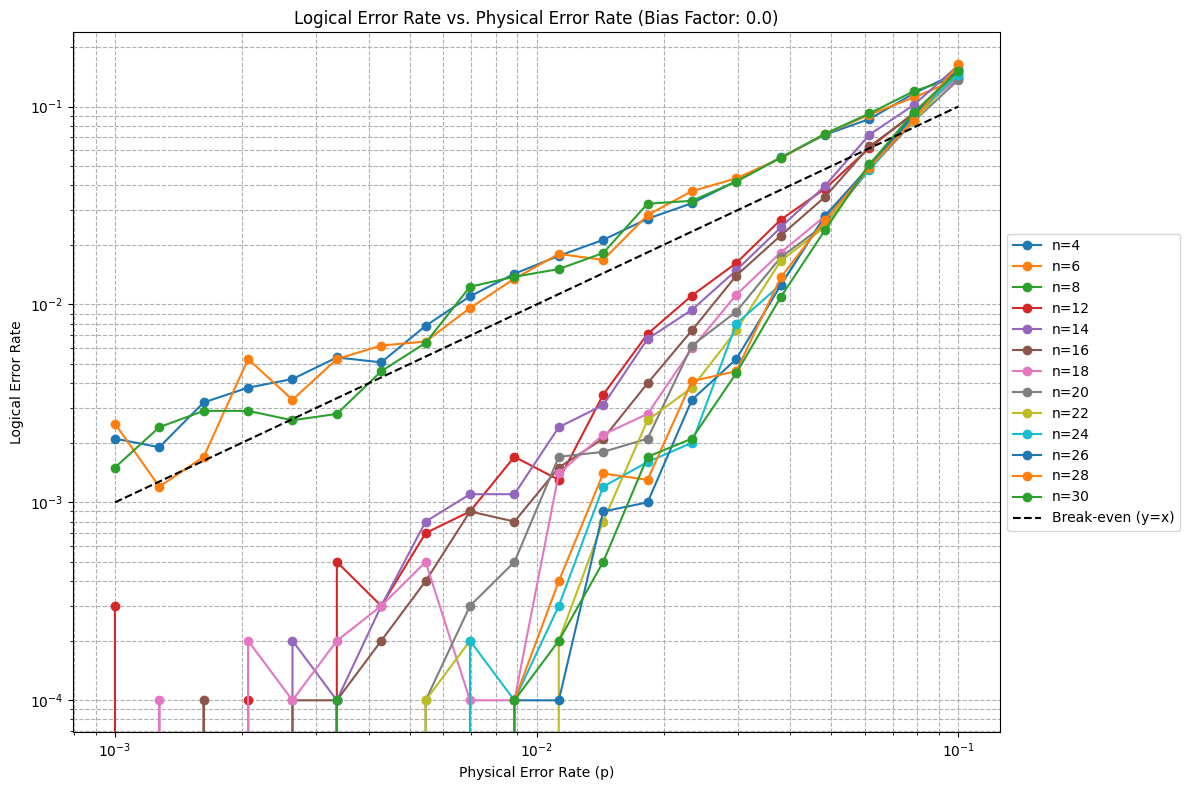

In [103]:
plot_logical_error_rates(ns, ps, bias_factor, log_errors_counts)

In [104]:
ns = [4, 6, 8, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]#, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
ps = np.logspace(-3, -1, 20).tolist()

bias_factor = 0.5
num_shots = 10000

log_errors_counts = run_simulation(ns, ps, bias_factor, num_shots)

Simulating for n=4...
Simulating for n=6...
Simulating for n=8...
Simulating for n=12...
Simulating for n=14...
Simulating for n=16...
Simulating for n=18...
Simulating for n=20...
Simulating for n=22...
Simulating for n=24...
Simulating for n=26...
Simulating for n=28...
Simulating for n=30...


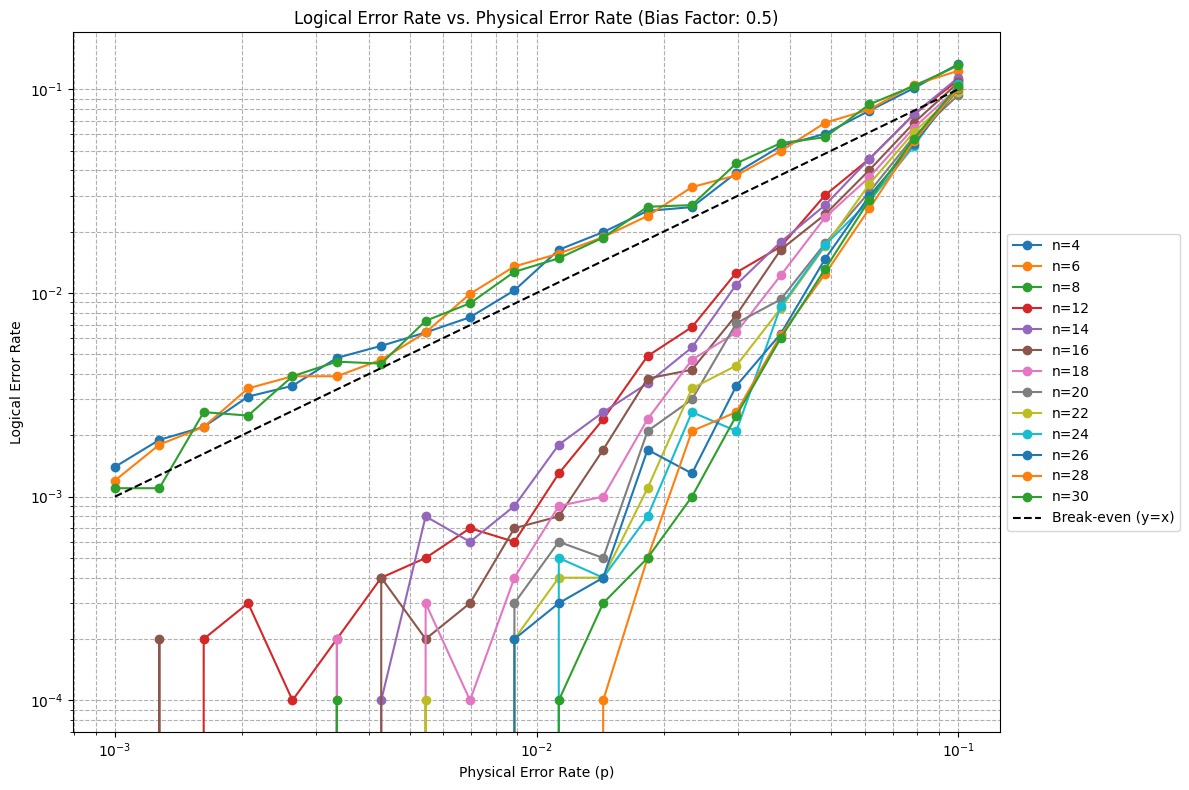

In [105]:
plot_logical_error_rates(ns, ps, bias_factor, log_errors_counts)